## Pablo Torre e Ignacio Jiménez

In [ ]:
from pyspark import SparkConf, SparkContext
import time
import numpy as np

In [ ]:
conf = SparkConf().setAppName('botnet')
sc = SparkContext(conf = conf)

24/03/05 20:00:44 WARN Utils: Your hostname, ignacio-XPS-15-9570 resolves to a loopback address: 127.0.1.1; using 10.152.224.49 instead (on interface wlp59s0)
24/03/05 20:00:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/05 20:00:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
def readFile (filename):
    '''
    Arguments:
    filename – name of the spam dataset file
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y)
    Y -- Train labels (0 if normal traffic, 1 if botnet)
    m rows: number of examples (m)
    Returns:
    An RDD containing the data of filename. Each example (row) of the file
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)
    '''
    # read the file
    rdd = sc.textFile(filename)
    # split the file into columns
    rdd = rdd.map(lambda x: x.split(","))
    # convert the columns into float and integer
    rdd = rdd.map(lambda x: ([float(xi) for xi in x[:-1]], int(x[-1])))
    return rdd


In [ ]:
def normalize (RDD_Xy):
    '''
    Arguments:
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    Returns:
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1)
    '''
    # get the number of examples
    m = RDD_Xy.count()
    # get the list of features
    rdd_list = RDD_Xy.map(lambda x: x[0])

    # calculate the mean and standard deviation
    mean = rdd_list.reduce(lambda x,y: np.add(x,y))
    mean = mean/m

    std = rdd_list.map(lambda x: np.power(np.subtract(x,mean),2)).reduce(lambda x,y: np.add(x,y))
    std = np.sqrt(std / m)

    # rescale the data
    RDD_Xy = RDD_Xy.map(lambda x: (np.append(np.divide(np.subtract(x[0],mean),std), 1), x[1]))
    return RDD_Xy

In [ ]:
def train (RDD_Xy, iterations, learning_rate, lambda_reg):
    '''
    Arguments:
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent
    lambda_reg – regularization rate
    Returns:
    A list or array containing the weights “w” and bias “b” at the end of the
    training process
    '''
    # get the number of examples
    m = RDD_Xy.count()

    # create w and b
    w = np.random.uniform(0,1,12)
    iterac = 0
    epsilon=0.00000001

    while(iterac < iterations):
        # calculate y_hat
        y_hat = RDD_Xy.map(lambda x: (1/(1+np.exp(-np.dot(w, x[0]))), x[1], x[0]))

        # calculate the loss
        loss = y_hat.map(lambda x: -np.log(x[0]+ epsilon)  if x[1] == 1 else -np.log(1-x[0]+ epsilon))
        loss_avg = loss.reduce(lambda x,y: x+y)/m + lambda_reg*np.sum(np.power((w[:-1]),2))/(2*(len(w)-1))

        # print Cost "j" and iteration
        print ("iteration",iterac," Cost:",loss_avg)

        # calculate the gradient
        grad = y_hat.map(lambda x: (x[0]-x[1])*x[2]).reduce(lambda x,y: np.add(x,y))
        grad = np.divide(grad,m) + lambda_reg*np.append(w[:-1],0)/(len(w)-1)

        # update w
        w = np.subtract(w,learning_rate*grad)

        iterac += 1

    return w


In [ ]:
def predict (w, X):
    '''
    Arguments:
    w -- weights
    b -- bias
    X – Example to be predicted
    Returns:
    Y_pred – a value (0/1) corresponding to the prediction of X
    '''
    # calculate the prediction
    y_hat = 1/(1+np.exp(-np.dot(w, X)))
    # calculate the prediction
    Y_pred = 1 if y_hat >= 0.5 else 0
    return Y_pred

def accuracy (w, RDD_Xy):
    '''
    Arguments:
    w -- weights
    b -- bias
    RDD_Xy – RDD containing examples to be predicted
    Returns:
    accuracy -- the number of predictions that are correct divided by the number
    of records (examples) in RDD_xy.
    Predict function can be used for predicting a single example
    '''
    # get the number of examples
    m = RDD_Xy.count()
    # calculate the prediction
    accuracy = RDD_Xy.map(lambda x: 1 if predict(w, x[0]) == x[1] else 0)
    accuracy = accuracy.reduce(lambda x,y: x+y)/m
    return accuracy

In [ ]:
#Execution parameters
nIter = 10
learningRate = 1.5
lambda_reg = 0.01
path = "./botnet_reduced_l.csv"


# read text_file in dataPath
X_y = readFile(path)

#Standardise
X_y = normalize(X_y)

#Train
t1=time.time()
ws= train(X_y, nIter, learningRate, lambda_reg)
t2=time.time()
print (f"time for {nIter} iterations: {t2-t1}")

acc = accuracy(ws, X_y)

#Results

print ("Final weights of the model:")
print (ws)
print (" ")
print ("Accuracy of the model:",acc,"%")
print (" ")

iteration 0  Cost: 1.482082308760138


iteration 1  Cost: 0.7844289225163308


iteration 2  Cost: 0.5056953695783504


iteration 3  Cost: 0.38008277179992367


iteration 4  Cost: 0.3161988564342199


iteration 5  Cost: 0.27991290635204175


iteration 6  Cost: 0.2572182216008607


iteration 7  Cost: 0.24190567451601253


iteration 8  Cost: 0.23095070386044808


iteration 9  Cost: 0.22274667050818603


time for 10 iterations: 54.378424644470215


Final weights of the model:
[-0.10102395 -0.91036509 -0.28209815 -0.11807121 -1.16953726  0.93126014
  0.24886251 -0.93835052  0.40998405  0.93857077  0.6713793  -0.04963858]
 
Accuracy of the model: 0.9266825 %
 


# Report data (normal train)

In [ ]:
#Execution parameters
nIter = 10
learningRate = 1.5
lambda_reg = 0.01
path = "./botnet_reduced_l.csv"

times = []
for l in [1,2,3,4,6,8]:
    sc.stop()
    conf = SparkConf().setAppName('botnet').setMaster(f'local[{l}]')
    sc = SparkContext(conf = conf)
    # read text_file in dataPath
    X_y = readFile(path)
    #Standardise
    X_y = normalize(X_y)
    #Train
    acc_time = 0
    for i in range(3):
        t1=time.time()
        ws= train(X_y, nIter, learningRate, lambda_reg)
        t2=time.time()
        acc_time += t2-t1
        print (f"time for {nIter} iterations: {t2-t1}")

    print ("Average time for training:",acc_time/3)
    times.append(acc_time/3)

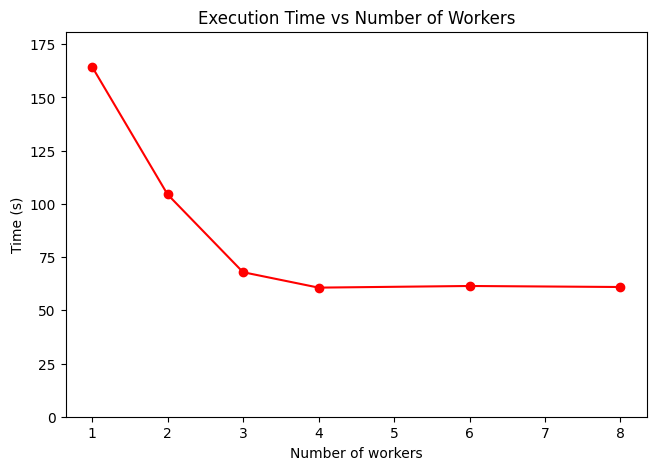

In [ ]:
from matplotlib import pyplot as plt

workers = [1,2,3,4,6,8]
times = [164.43, 104.44, 67.90, 60.65, 61.42, 60.94]

# graph for the time of execution
plt.figure( figsize=(7.5, 5))
# values from max to 0
plt.plot(workers, times, 'ro-')
plt.xlabel('Number of workers')
plt.ylabel('Time (s)')
plt.title('Execution Time vs Number of Workers')
# Set y-axis limits from 0 to the maximum value in times
plt.ylim(0, max(times)*1.1)
plt.show()



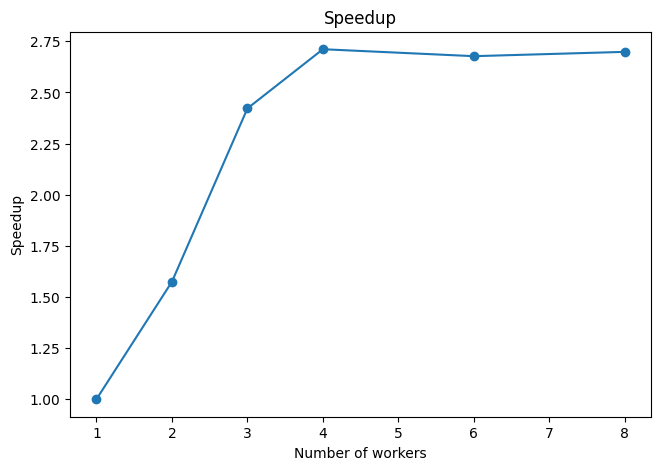

In [ ]:
# graph for the speedup

speedup = [times[0]/t for t in times]
plt.figure( figsize=(7.5, 5))
plt.plot(workers, speedup, 'o-')
plt.xlabel('Number of workers')
plt.ylabel('Speedup')
plt.title('Speedup')
plt.show()
